In [1]:
import scanpy as sc
import anndata
#import pl
#import tl
import numpy as np
import time as time

# Load Dataset
filelocation = r"datasets/VBh_converted.h5ad"
adata = anndata.read_h5ad(filelocation)

# subsampling
sc.pp.subsample(adata, 0.2)

# normalizing
adata.X = np.arcsinh(adata.X / 10)

# calc knn
sc.pp.neighbors(adata, n_neighbors=20)

/home/felix/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


**HUMAP function**

In [2]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs

import matplotlib.pyplot as plt

def _humap(adata, n_scales: int = 1, factor: float = 0.5, copy: bool = False):
    
    # check if knn graph has been calculated beforehand
    assert 'connectivities' in adata.obsp.keys(), "No knn graph found. Calculate with scanpy.tl.neighbors(...)"
    
    scales = list()
    scales.append(adata.copy())
    
    for s in range(n_scales):
        speichi = scales[-1].copy()
        #sc.pp.neighbors(speichi)
        c = speichi.obsp['connectivities']
        T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))
        D, V = eigs(T.T, which='LM')

        # landmark probabilities
        pi = V[:, 0]
        pi = pi.real
        pi /= pi.sum()

        # indices of landmarks sorted by probability
        lm_ind = pi.argsort()
        
        speichi = speichi[lm_ind[:int(len(speichi)*factor)]]
        print(f"Calculating scale {s} with {len(speichi)} cells")
        
        plt.plot(pi[pi.argsort()][::-1])
        plt.show()
        
        # normalizing
        speichi.X = np.arcsinh(speichi.X / 10)
        
        # (re)calculate knn
        sc.pp.neighbors(speichi, n_neighbors=20)
        # calculate umap embedding
        sc.tl.umap(speichi)
        scales.append(speichi)
        
    # removing first element
    scales.pop(0)
    adata.uns['HUMAP_scales'] = scales
    return adata if copy else None
    


Calculating scale 0 with 10357 cells


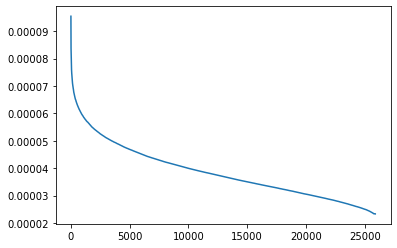

Calculating scale 1 with 4142 cells


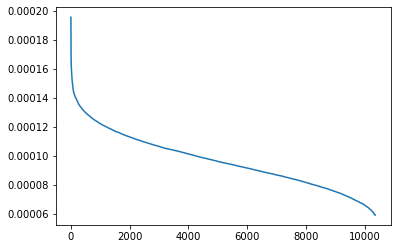

Calculating scale 2 with 1656 cells


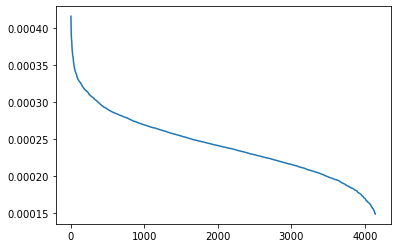

In [3]:
_humap(adata, n_scales = 3, factor = 0.4)

Scale


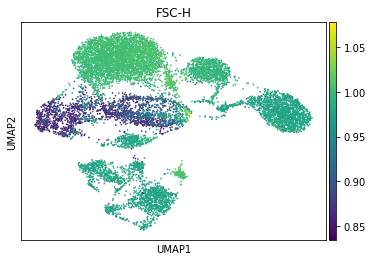

Scale


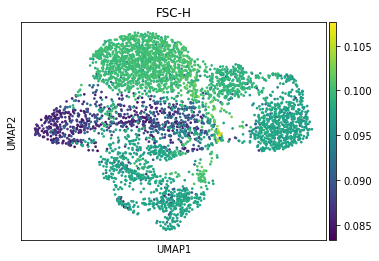

Scale


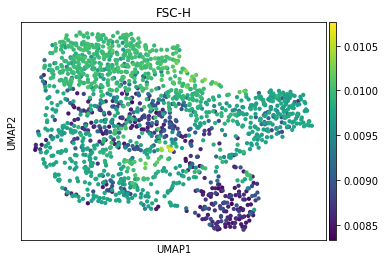

In [4]:
for s in adata.uns['HUMAP_scales']:
    print("Scale")
    sc.pl.umap(s, color=adata.var_names.values[0])

**Calculate Landmarks**

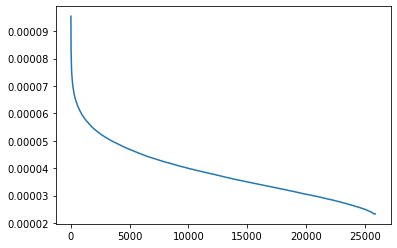

In [5]:
from scipy.sparse import csr_matrix, spdiags
from scipy.sparse.linalg import eigs
# concentrated

c = adata.obsp['connectivities']

T = c.multiply(csr_matrix(1.0 / np.abs(c).sum(1)))

D, V = eigs(T.T, which='LM')

pi = V[:, 0]

pi = pi.real

pi /= pi.sum()

Pi = spdiags(pi, 0, pi.shape[0], pi.shape[0])

plt.plot(pi[pi.argsort()][::-1])
plt.show()


Taking 1.0% of all cells as landmarks
--> 258 of originally 25893 cells


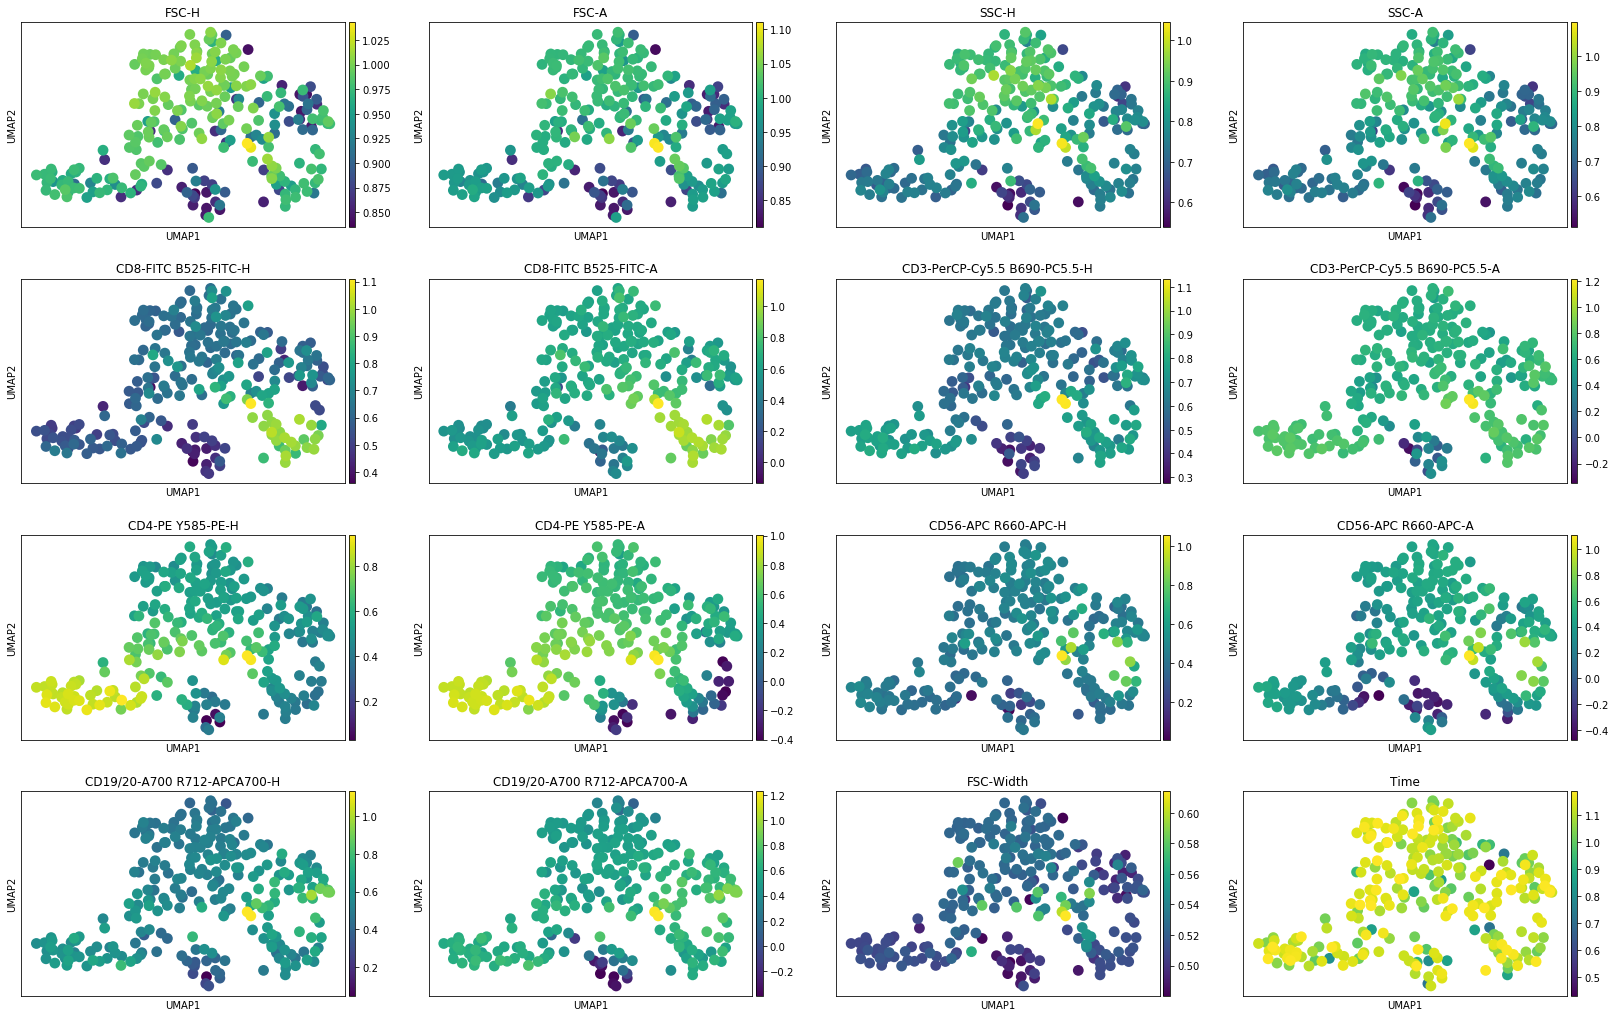

In [6]:
# copy original anndata object
speichi = adata.copy()

percentage = 0.01
# reduce it to certain fraction (landmarks)
speichi = speichi[pi.argsort()[:int(len(adata)*percentage)]]
print(f"Taking {percentage*100}% of all cells as landmarks")
print(f"--> {len(speichi.X)} of originally {len(adata.X)} cells")

# normalizing
speichi.X = np.arcsinh(speichi.X / 10)
# (re)calculate knn
sc.pp.neighbors(speichi, n_neighbors=20)
# calculate umap embedding
sc.tl.umap(speichi)
# plot umap embedding
sc.pl.umap(speichi, color=adata.var_names.values)

25893 of originally 25893 cells


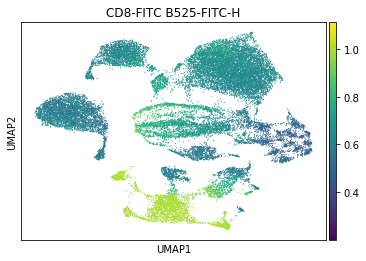

22980 of originally 25893 cells


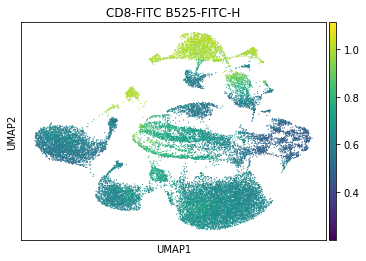

20067 of originally 25893 cells


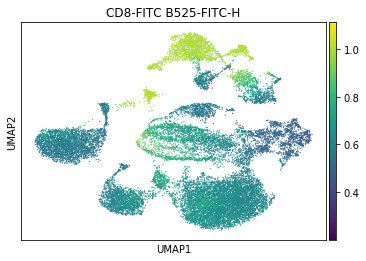

17154 of originally 25893 cells


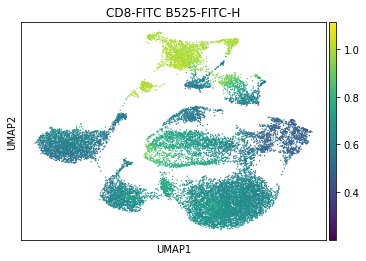

14241 of originally 25893 cells


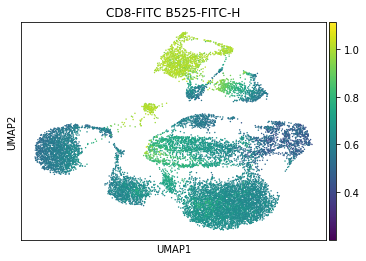

11328 of originally 25893 cells


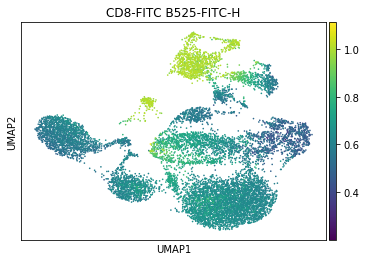

8415 of originally 25893 cells


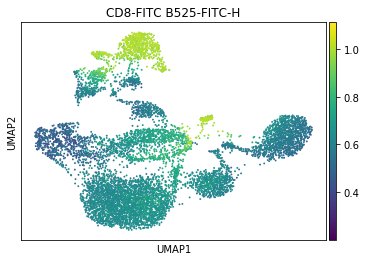

5502 of originally 25893 cells


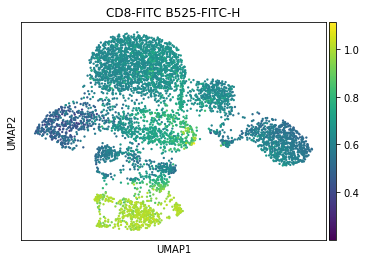

2589 of originally 25893 cells


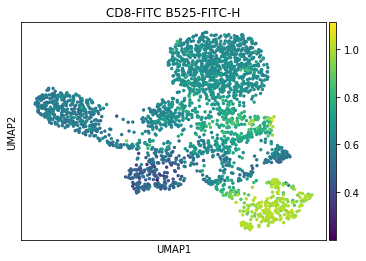

In [7]:
for part in np.linspace(1,0.1,9):
    # copy original anndata object
    speichi = adata.copy()
    # reduce it to certain fraction (landmarks)
    speichi = speichi[pi.argsort()[:int(len(adata)*part)]]
    
    print(f"{len(speichi.X)} of originally {len(adata.X)} cells")
    
    # normalizing
    speichi.X = np.arcsinh(speichi.X / 10)
    # (re)calculate knn
    sc.pp.neighbors(speichi, n_neighbors=20)
    # calculate umap embedding
    sc.tl.umap(speichi)
    # plot umap embedding
    sc.pl.umap(speichi, color=adata.var_names.values[4])